# Project Setup

- mount to google drive
- prepare the packages necessary

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!pip install texthero # used for later data preprocessing task

     |████████████████████████████████| 245kB 4.2MB/s 
     |████████████████████████████████| 1.4MB 6.9MB/s 
  Created wheel for nltk: filename=nltk-3.5-cp36-none-any.whl size=1434674 sha256=169a9e5c2dda072a5a4581d5655f7a517c71cae9ffd176b2b44dcf49403094b0
  Stored in directory: /root/.cache/pip/wheels/ae/8c/3f/b1fe0ba04555b08b57ab52ab7f86023639a526d8bc8d384306
Successfully built nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [ ]:
import os
import pandas as pd
import numpy as np
import texthero as hero
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, plot_roc_curve
import random
from xgboost import XGBClassifier

# necessary packages from tensorflow and keras
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential

import pickle
import matplotlib.pyplot as plt
os.chdir('/content/drive/My Drive/gsa_ai_challenge')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Data Preprocessing

- read in the data (clause text and classification)
- use pandas for some basic statistics 
- preprocess the data:
    - fill NA
    - remove stopwords
    - remove digits, puncuations
    - down case the words
    - remove whitespace
    - add/delete other preprocessing choices if necessary


In [ ]:
df = pd.read_csv('data/AI_ML_Challenge_Training_Data_Set_1_v1.csv')
df.describe()

,Clause ID,Classification
count,7879.000000,7879.000000
mean,4635.594492,0.186826
std,2676.924909,0.389796
min,0.000000,0.000000
25%,2330.500000,0.000000
50%,4643.000000,0.000000
75%,6958.500000,0.000000
max,9269.000000,1.000000


In [ ]:
label = []
clause = []
with open('augment_data/data_augmented.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        parts = line.split('\t', 1)
        label.append(parts[0])
        clause.append(parts[1])

s1 = pd.Series(label)
s2 = pd.Series(clause)
df = pd.concat([s1,s2], axis=1).rename(columns={0:'Classification', 1:'clean_text'})
df = df[['clean_text', 'Classification']]
df.describe()

,clean_text,Classification
count,34290,34290
unique,34016,2
top,confidentiality\n,0
freq,6,27135


In [ ]:
test = "b.	Client Data refers to the data client or any user uploads or otherwise supplies to or stores in the services under clients account."
df['test'] = test
df['test'].pipe(hero.clean, custom_pipeline)[0]

'b. client data refers to the data client or any user uploads or otherwise supplies to or stores in the services under clients account.'

In [ ]:
from texthero import preprocessing
custom_pipeline = [preprocessing.fillna,
                   preprocessing.lowercase,
                   preprocessing.remove_whitespace,
                   ]

We found that most of the clause text has a label 0, which makes the dataset a skewed one. In this case, we should not only care about accuracy for testing but also the false negative rate because we might place too much emphasis on label 0. In conclusion, we will value F1 score more than accuracy.

In [ ]:
# clean the data with texthero
# we can change the preprocessing steps by alternating pipe
df['clean_text'] = df['Clause Text'].pipe(hero.clean, custom_pipeline)

# clean duplicates
df = df.drop_duplicates(subset='clean_text')

cleaned_df = df[['clean_text','Classification']]
# cleaned_df.head()
# cleaned_df.sort_values('clean_text', ascending=False)
temp = cleaned_df[cleaned_df['clean_text'].str.len() > 10]
temp.head()
temp.to_csv('data/all_data_cleaned.csv')

In [ ]:
# customized keywords related data
def get_customized_dataset(data, keywords = ['audit']): 
    index_list = []
    for (index, item) in enumerate(data['clean_text']):
        for keyword in keywords:
            if keyword in item:
                index_list.append(index)
    return data.iloc[index_list,:]

keywords_list = ["audit", "pay for audit", "government will pay for audit"]
keywords_list = ["automatic renewals", "automatic yearly", "automatic"]
custom_df = get_customized_dataset(cleaned_df, keywords_list)

In [ ]:
custom_df.head()

,clean_text,Classification
32,initial term agreement commences effective dat...,1
85,evaluation company solution provided customer ...,0
103,training course company academic network use g...,0
311,support requests submitted email automatically...,0
353,h usage report solution automatically generate...,0


In [ ]:
df = pd.read_csv('data/training_data_len.csv')
df = df[['clean_text', 'Classification']]
len(df)

6858

# Visualize the dataset with WordCloud and Principle Components

In [ ]:
df['pca'] = (
   df['Clause Text']
   .pipe(hero.clean)
   .pipe(hero.tfidf)
   .pipe(hero.pca)
)
hero.scatterplot(df, 'pca', color='Classification', title="PCA Clause")

From the image above, we see that on 2D plane, two labels are some how clustered but very close. There are many outliers for both class as well. Now let's try using a WordCloud to see what word/phrase appear the most

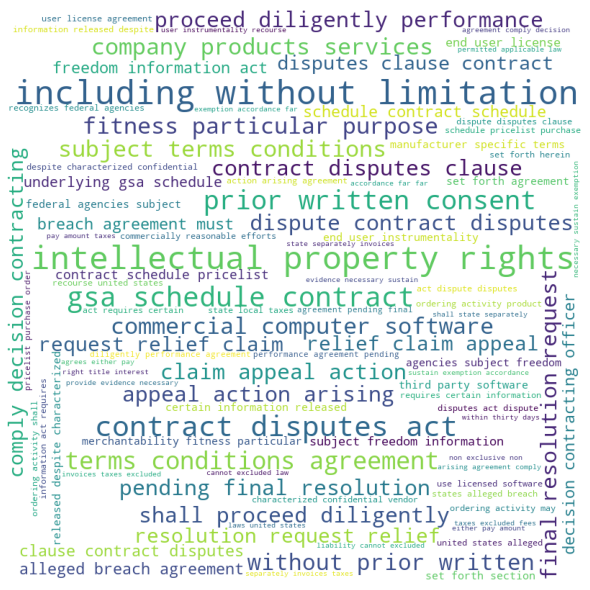

In [ ]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 

# Bag of words vectorizer
# adjust ngram_range if you want to include bigram, trigram, etc.
vectorizer = CountVectorizer(ngram_range=(3,3))

new_df = df.copy()
new_df['clean_text'] = new_df['Clause Text'].pipe(hero.clean)


label_1_text = ' '.join(new_df[new_df['Classification']==1]['clean_text'])
label_0_text = ' '.join(new_df[new_df['Classification']==0]['clean_text'])
stopwords = set(STOPWORDS) 

# here we transform on the label_0 text so we only care about clauses that's 
# classified as 0
text = vectorizer.fit_transform([label_0_text])

sum_words = text.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

words_dict = dict(words_freq)

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate_from_frequencies(words_dict)
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

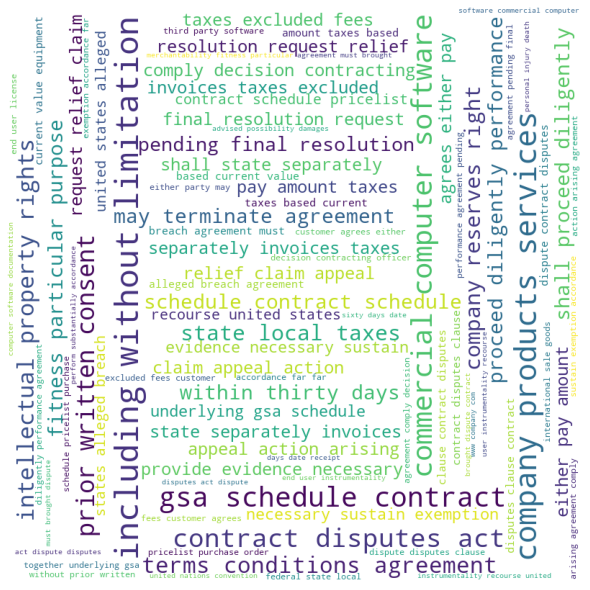

In [ ]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 

# Bag of words vectorizer
# adjust ngram_range if you want to include bigram, trigram, etc.
vectorizer = CountVectorizer(ngram_range=(3,3))

new_df = df.copy()
new_df['clean_text'] = new_df['Clause Text'].pipe(hero.clean)


label_1_text = ' '.join(new_df[new_df['Classification']==1]['clean_text'])
label_0_text = ' '.join(new_df[new_df['Classification']==0]['clean_text'])
stopwords = set(STOPWORDS) 

# here we transform on the label_0 text so we only care about clauses that's 
# classified as 0
text = vectorizer.fit_transform([label_1_text])

sum_words = text.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

words_dict = dict(words_freq)

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate_from_frequencies(words_dict)
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

Since WordCloud only identifies the word with highest frequency, playing around with ngram_range might be helpful but most likely manual inspection is not going to outperform AI or ML training algorithm. Now we move on to find a baseline model using machine learning approach.

# Baseline Model
- prepare the train and validation data
- fit the data into random forest with help of sklearn
- add xgboost to see if there's any improvement

In [ ]:
# use train test split to prepare the data
def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(1)
   tf.random.set_seed(1)
   np.random.seed(1)
   random.seed(1)

reset_random_seeds()

df = pd.read_csv('data/all_data_cleaned.csv')
df = df[['clean_text', 'Classification']]

df_train, df_val = train_test_split(df, train_size = 0.8, random_state=0)
X_train, y_train = df_train['clean_text'], df_train['Classification']
X_val, y_val = df_val['clean_text'], df_val['Classification']

In [ ]:
df.head()

,clean_text,Classification
0,18. governing law: this agreement shall be gov...,0
1,"1.8 modification. we may modify, update, or di...",1
2,except as otherwise expressly provided in this...,0
3,8.3. the benefit and burdens of this agreement...,1
4,definitions,0


In [ ]:
#from nltk.corpus import stopwords
#stop = stopwords.words('english')

# fit into a pipeline of tf-idf vectorizer and a random forest classifier 
pipe = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(2,3))),
                                  ('rf', RandomForestClassifier()) ])

#                 ('rf', RandomForestClassifier(n_estimators=200, class_weight='balanced')) ])

# start training
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(2, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None

In [ ]:
from sklearn.metrics import brier_score_loss
y_pred = pipe.predict(X_val)
y_pred_prob = pipe.predict_proba(X_val)
brier_score_loss(y_val, y_pred)

0.19104268719384185

confusion matrix is shown below:
 [[5437   27]
 [1192  202]]


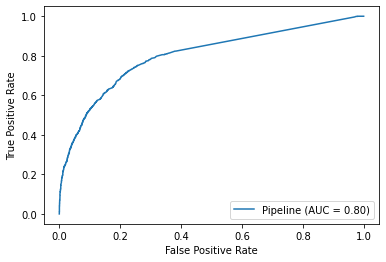

In [ ]:
# get the prediction on validation set

y_pred = pipe.predict(X_val)
y_pred_prob = pipe.predict_proba(X_val)
# use confusion matrix to understand how the baseline model performs
print("confusion matrix is shown below:\n", confusion_matrix(y_val, y_pred))

# visualize the AUC curve 
rf_disp = plot_roc_curve(pipe, X_val, y_val)
plt.show()

      len_char
5833       319
2075        55
1310       282
1946       258
6726       182
...        ...
905        373
5192       394
3980       297
235         28
5157       467

[5515 rows x 1 columns]
[[1923    0]
 [ 441    0]]


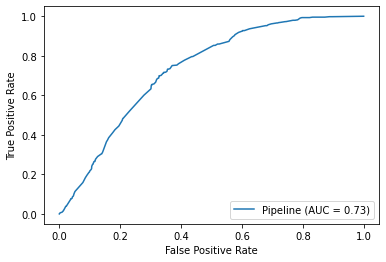

In [ ]:
# add XgBoost

# use train test split to prepare the data
df_train, df_val = train_test_split(temp_df, train_size = 0.7)
X_train, y_train = df_train.iloc[:, 0:1], df_train['Classification']
X_val, y_val = df_val.iloc[:, 0:1], df_val['Classification']

print(X_train)
from xgboost import XGBClassifier

pipe = Pipeline([
                 # only one line replacement from random forest to xgboost
                 ('xgb', XGBClassifier())
                 ])
pipe.fit(X_train,y_train)

y_pred = pipe.predict(X_val)
y_pred_prob = pipe.predict_proba(X_val)

print(confusion_matrix(y_val, y_pred))

rf_disp = plot_roc_curve(pipe, X_val, y_val)
plt.show()

From the result above, we find machine learning baseline on accuracy is actually very high, above 80%. However, though we have a good performance on accuracy, we see that the prediction on positive (label 1) class is very bad because only 53 out of (231+52) 283 clauses are correctly predicted, and this is due to the overwhelming large amount of data in negative label. Therefore, our goal in the next few sections is to find models that perform better on positive class while retaining high accuracy and performance for negative class. 

# Document Similarity
- split train test data with a customizable ratio
- use the test set to perform document similarity
- compute the similarity score with cosine similarity and decide 1/0

In [ ]:
# split out the dataset into 1 and 0 label
true_doc = cleaned_df[cleaned_df['Classification'] == 1]
false_doc = cleaned_df[cleaned_df['Classification'] == 0]
true_doc.head()

# set total test data and ratio of split
TOTAL_TEST = 400
ratio = 0.8 # split of true false label in test set

In [ ]:
# split the true false document
def get_train_test(total, ratio, true_doc, false_doc):
    amount_true = total * ratio
    amount_false = total * (1-ratio)

    # split the true-labeled data
    split_ratio_true = amount_true / len(true_doc)
    train_true, test_true = train_test_split(true_doc['clean_text'], 
                                             test_size=split_ratio_true,
                                             shuffle=True)
    
    # split the false-labeled data
    split_ratio_false = amount_false / len(false_doc)
    train_false, test_false = train_test_split(false_doc['clean_text'], 
                                             test_size=split_ratio_false,
                                             shuffle=True)
    
    # return the train_true, train_false, test_true, and test_false data
    return train_true, test_true, train_false, test_false

train_true, test_true, train_false, test_false = get_train_test(TOTAL_TEST, ratio, true_doc, false_doc)

In [ ]:
# get all train data 
all_train = pd.concat([train_true, train_false], axis=0)
all_train.shape

tf_vector = TfidfVectorizer(ngram_range=(1,2))
tf_vector.fit_transform(all_train)

<6560x111027 sparse matrix of type '<class 'numpy.float64'>'
	with 491321 stored elements in Compressed Sparse Row format>

In [ ]:
# perform transformation on all train test set to be ready for the cosine similarity
mat_train_true = tf_vector.transform(train_true)
mat_train_false = tf_vector.transform(train_false)
mat_test_true = tf_vector.transform(test_true)
mat_test_false = tf_vector.transform(test_false)

mat_test_true.toarray().shape

(320, 111027)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# keep track of confusion matrix
TP, TN, FP, FN = 0, 0, 0, 0

for i in range(mat_test_true.shape[0]):
    # compute similarity with all true document
    true_score = cosine_similarity(mat_train_true, mat_test_true.toarray()[i].reshape(1,-1))
    # take the average
    true_score = np.average(true_score)

    # compute similarity with all false document
    false_score = cosine_similarity(mat_train_false, mat_test_true.toarray()[i].reshape(1,-1))
    # take the average
    false_score = np.average(false_score)

    # update counter in confusion matrix
    if true_score >= false_score:
        TP += 1
    else:
        FN += 1

for i in range(mat_test_false.shape[0]):
    true_score = cosine_similarity(mat_train_true, mat_test_false.toarray()[i].reshape(1,-1))
    true_score = np.average(true_score)

    false_score = cosine_similarity(mat_train_false, mat_test_false.toarray()[i].reshape(1,-1))
    false_score = np.average(false_score)

    # update counter in confusion matrix
    if true_score < false_score:
        TN += 1
    else:
        FP += 1

print(TP, TN, FP, FN)

319 12 68 1


# Move on to Word Embedding and Deep Learning
- Train Word2Vec embedding with Fasttext from facebook research
- use the pretrained word embedding on simple Recurrent Neural Network
- Perform K-fold analysis on the fasttext classification

In [ ]:
# install necessary packages
!pip install fasttext

# use train test split to prepare the data
df_train, df_val = train_test_split(df, train_size = 0.8, random_state=0)
X_train, y_train = df_train['clean_text'], df_train['Classification']
X_val, y_val = df_val['clean_text'], df_val['Classification']

In [ ]:
 import fasttext
 # prepare the data for fasttext
 # have to label the y data according to the format
 def get_training_file(X,y,is_train=True,verbose=False):
    y = y.apply(lambda x:f'__label__{x}')
    df = (y+' '+X)
    filename = 'data/fasttext.valid.txt'
    if is_train:
        filename='data/fasttext.train.txt'
    
    df.to_csv(filename, index=False, header=False)
    if verbose:
        print(df.head())

# for convenience we define a function to print confusion matrix
def conf_matrix(data, model, y_val):
    y_pred = data.map(lambda x:0 if model.predict(x)[0][0].endswith('0') else 1 )
    y_pred_proba = data.map(lambda x: model.predict(x)[0])
    return confusion_matrix(y_val, y_pred)

In [ ]:
# X_train and y_train are previously defined in the baseline model
# take a look at the post-precessed input text
get_training_file(X_train, y_train, verbose=True)
get_training_file(X_val, y_val, is_train=False, verbose=True)

5764    __label__0 application page means webpage part...
1551    __label__0 licensee shall entitled assign sub ...
415     __label__0 critical systems technology include...
4135                       __label__0 limitation recovery
4784    __label__0 license applicable product data der...
dtype: object
4963    __label__0 agreement together underlying agenc...
1668    __label__0 audit rights company may audit cust...
3578    __label__0 term agreement period seven years e...
4501    __label__0 maintenance fees client pay company...
119     __label__1 agreement may modified except writt...
dtype: object


In [ ]:
# essentially the supervised approach is train on word2vec and classify on a linear model
model_hand_tune = fasttext.train_supervised(input="data/fasttext.train.txt", 
                                  lr=0.1, 
                                  epoch=50, 
                                  wordNgrams=1)

In [ ]:
print(conf_matrix(X_val, model_hand_tune, y_val))

[[1103   58]
 [ 237   52]]


In [ ]:
# fast text enables auto tune
model_auto_tune = fasttext.train_supervised(input='data/fasttext.train.txt', 
                                            autotuneValidationFile='data/fasttext.valid.txt',
                                            autotuneDuration=100)

ValueError: ignored

In [ ]:
print(conf_matrix(X_val, model_auto_tune, y_val))

In [ ]:
model_auto_f1 = fasttext.train_supervised(input='data/fasttext.train.txt', 
                                  autotuneValidationFile='data/fasttext.valid.txt', 
                                  autotuneMetric="f1:__label__1",
                                  autotuneDuration=300)

In [ ]:
print(conf_matrix(X_val, model_auto_f1, y_val))

[[988 101]
 [147 136]]


In the cells below, we perform K-Fold validation on the fasttext results to better understand how the model performs

In [ ]:
# use K-Fold to prepare the data
kf = KFold(n_splits=5, shuffle=False)
counter = 0
for train_index, test_index in kf.split(cleaned_df):
    X_train, X_test = cleaned_df.iloc[train_index, :-1]['clean_text'], cleaned_df.iloc[test_index, :-1]['clean_text']
    y_train, y_test = cleaned_df.iloc[train_index, 1:]['Classification'], cleaned_df.iloc[test_index, 1:]['Classification']
    
    # update train test file for fasttext
    get_training_file(X_train, y_train, verbose=False)
    get_training_file(X_test, y_test, is_train=False, verbose=False)

    # use the auto_supervised model
    model_auto_f1 = fasttext.train_supervised(input='data/fasttext.train.txt', 
                                  autotuneValidationFile='data/fasttext.valid.txt', 
                                  autotuneMetric="f1:__label__1",
                                  autotuneDuration=600)
    
    # show confusion matrix
    print("The confusion matrix for {0}'s fold".format(counter))
    print(conf_matrix(X_test, model_auto_f1, y_test))
    counter += 1
    


The confusion matrix for 0's fold
[[1172  108]
 [ 157  139]]
The confusion matrix for 1's fold
[[1182   96]
 [ 145  153]]
The confusion matrix for 2's fold
[[1193   76]
 [ 161  146]]
The confusion matrix for 3's fold
[[1133  155]
 [ 145  143]]
The confusion matrix for 4's fold
[[1226   66]
 [ 130  153]]


# Deep Learning with Recurrent Neural Network and Embedding Layer
- setup model structure with keras
- train the model based on previously defined train and validation data
- integrate the embedding layer of fasttext into RNN model

In [ ]:
# necessary packages from tensorflow and keras
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential

In [ ]:
# tokenize the training data

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_text'])
word_index = tokenizer.word_index
print(word_index) # number of unique words

{'company': 1, 'software': 2, 'agreement': 3, 'shall': 4, 'customer': 5, 'use': 6, 'services': 7, 'party': 8, 'may': 9, 'information': 10, 'license': 11, 'terms': 12, 'product': 13, 'service': 14, 'licensee': 15, 'provided': 16, 'including': 17, 'data': 18, 'applicable': 19, 'rights': 20, 'support': 21, 'ordering': 22, 'activity': 23, 'third': 24, 'licensed': 25, 'without': 26, 'user': 27, 'contract': 28, 'order': 29, 'subject': 30, 'parties': 31, 'products': 32, 'access': 33, 'otherwise': 34, 'confidential': 35, 'time': 36, 'u': 37, 'fees': 38, 'documentation': 39, 'provide': 40, 'law': 41, 'right': 42, 'written': 43, 'section': 44, 'limited': 45, 'term': 46, 'liability': 47, 'accordance': 48, 'warranty': 49, 'c': 50, 'upon': 51, 'set': 52, 'termination': 53, 'except': 54, 'non': 55, 'breach': 56, 'forth': 57, 'end': 58, 'government': 59, 'licensor': 60, 'conditions': 61, 'means': 62, 'days': 63, 'subscription': 64, 'content': 65, 'event': 66, 'period': 67, 'b': 68, 'available': 69, '

In [ ]:
# pad the sequence
MAX_LEN = 128
X = sequence.pad_sequences(tokenizer.texts_to_sequences(df['clean_text']), 
                                 maxlen = MAX_LEN,
                                 padding='post')
y = df['Classification']
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=0)

The first approach we tried is to tokenize the words with a keras embedding layer. But later we are going to retrieve the word embedding from fasttext and use it directly inside the RNN model

In [ ]:
class CLF(keras.Model):

    def __init__(self):
        super(CLF, self).__init__()
        self.embed = layers.Embedding(len(word_index)+1, 
                                      300, 
                                      input_length=MAX_LEN)
        self.lstm = layers.LSTM(32, recurrent_dropout=0.3)
        self.dense1 = layers.Dense(128, activation='relu')
        self.dense2 = layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        X = self.embed(inputs)
        l1 = self.lstm(X)
        l2 = self.dense1(l1)
        output = self.dense2(l2)
        return output

clf = CLF()

In [ ]:
clf.compile(loss='binary_crossentropy', 
            optimizer='adam', 
            metrics=['accuracy'])

NameError: ignored

In [ ]:

model = Sequential()
# embed into 300-D
model.add(layers.Embedding(len(word_index)+1, 300, input_length=MAX_LEN))
model.add(layers.LSTM(32, recurrent_dropout=0.3))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_val, y_val), 
          epochs=20, 
          batch_size=32, 
          verbose=2)

# evaluation at the end
scores = model.evaluate(X_val, y_val, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/20
172/172 - 82s - loss: 0.5154 - accuracy: 0.7904 - val_loss: 0.5066 - val_accuracy: 0.7937
Epoch 2/20
172/172 - 81s - loss: 0.5013 - accuracy: 0.7969 - val_loss: 0.5095 - val_accuracy: 0.7908
Epoch 3/20
172/172 - 82s - loss: 0.4860 - accuracy: 0.8102 - val_loss: 0.5191 - val_accuracy: 0.7864
Epoch 4/20
172/172 - 81s - loss: 0.4803 - accuracy: 0.8110 - val_loss: 0.5265 - val_accuracy: 0.7872
Epoch 5/20
172/172 - 81s - loss: 0.4715 - accuracy: 0.8139 - val_loss: 0.5327 - val_accuracy: 0.7872
Epoch 6/20
172/172 - 81s - loss: 0.4652 - accuracy: 0.8153 - val_loss: 0.4808 - val_accuracy: 0.7864
Epoch 7/20
172/172 - 81s - loss: 0.4104 - accuracy: 0.8234 - val_loss: 0.4718 - val_accuracy: 0.8003
Epoch 8/20
172/172 - 81s - loss: 0.3702 - accuracy: 0.8443 - val_loss: 0.4741 - val_accuracy: 0.7843
Epoch 9/20
172/172 - 81s - loss: 0.3317 - accuracy: 0.8709 - val_loss: 0.4932 - val_accuracy: 0.7850
Epoch 10/20
172/172 - 81s - loss: 0.3077 - accuracy: 0.8903 - val_loss: 0.4614 - val_accura

In [ ]:
y_pred = model.predict(X_val)
y_pred = y_pred >= 0.5
print(confusion_matrix(y_val, y_pred))

[[925 164]
 [124 159]]


# Data Augmentation for Positive Label data

In [ ]:
!pip install nlpaug 

     |████████████████████████████████| 102kB 2.4MB/s 


In [ ]:
from nlpaug.util.file.download import DownloadUtil
DownloadUtil.download_word2vec(dest_dir='./pretrain_embedding') # Download word2vec model
DownloadUtil.download_glove(model_name='glove.6B', dest_dir='./pretrain_embedding') # Download GloVe model
DownloadUtil.download_fasttext(model_name='wiki-news-300d-1M', dest_dir='./pretrain_embedding') # Download fasttext model

In [ ]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

from nlpaug.util import Action

In [ ]:
# model_type: word2vec, glove or fasttext
text = "The quick brown fox jumps over the lazy dog"
aug = naw.WordEmbsAug(
    model_type='glove', model_path='pretrain_embedding/glove.6B.50d.txt',
    action="insert")
augmented_text = aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

Original:
The quick brown fox jumps over the lazy dog
Augmented Text:
The quick brown jullundur fox jumps over the muvunyi lazy dog


In [ ]:
# model_type: word2vec, glove or fasttext
text = "The quick brown fox jumps over the lazy dog"
aug = naw.WordEmbsAug(
    model_type='fasttext',
    model_path='pretrain_embedding/wiki-news-300d-1M.vec',
    action="insert")
augmented_text = aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

Original:
The quick brown fox jumps over the lazy dog
Augmented Text:
Akapusi The quick Floreasca brown fox jumps over the lazy dog


In [ ]:
aug = naw.SynonymAug(aug_src='ppdb', model_path='pretrain_embedding/ppdb-2.0-tldr.gz')
augmented_text = aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

UnicodeDecodeError: ignored

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
aug = naw.SynonymAug(aug_src='wordnet')
augmented_text = aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

Original:
The quick brown fox jumps over the lazy dog
Augmented Text:
The warm john brown fox jumps over the lazy dog


In [ ]:
#  # necessary packages from tensorflow and keras
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential

In [ ]:
# tokenize the training data

tokenizer = Tokenizer()
tokenizer.fit_on_texts(cleaned_df['clean_text'])
word_index = tokenizer.word_index
print(word_index) # number of unique words

In [ ]:
# pad the sequence
MAX_LEN = 128
X = sequence.pad_sequences(tokenizer.texts_to_sequences(cleaned_df['clean_text']), 
                                 maxlen = MAX_LEN,
                                 padding='post')
y = cleaned_df['Classification']
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=0)

# Recurrent Neural Network with FastText as Pre-trained Embedding Layer

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Jul 29 16:09:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# necessary packages from tensorflow and keras
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential

# tokenize the training data

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_text'])
word_index = tokenizer.word_index
print(word_index) # number of unique words

{'company': 1, 'software': 2, 'agreement': 3, 'shall': 4, 'customer': 5, 'use': 6, 'services': 7, 'party': 8, 'may': 9, 'information': 10, 'license': 11, 'terms': 12, 'product': 13, 'service': 14, 'licensee': 15, 'provided': 16, 'including': 17, 'data': 18, 'applicable': 19, 'rights': 20, 'support': 21, 'ordering': 22, 'activity': 23, 'third': 24, 'licensed': 25, 'without': 26, 'user': 27, 'contract': 28, 'order': 29, 'subject': 30, 'parties': 31, 'products': 32, 'access': 33, 'otherwise': 34, 'confidential': 35, 'time': 36, 'u': 37, 'fees': 38, 'documentation': 39, 'provide': 40, 'law': 41, 'right': 42, 'written': 43, 'section': 44, 'limited': 45, 'term': 46, 'liability': 47, 'accordance': 48, 'warranty': 49, 'c': 50, 'upon': 51, 'set': 52, 'termination': 53, 'except': 54, 'non': 55, 'breach': 56, 'forth': 57, 'end': 58, 'government': 59, 'licensor': 60, 'conditions': 61, 'means': 62, 'days': 63, 'subscription': 64, 'content': 65, 'event': 66, 'period': 67, 'b': 68, 'available': 69, '

In [ ]:
# pad the sequence
MAX_LEN = 128
X = sequence.pad_sequences(tokenizer.texts_to_sequences(df['clean_text']), 
                                 maxlen = MAX_LEN,
                                 padding='post')
y = df['clean_text']
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=0)

In [ ]:
# store the vector for each word in this embedding dictionary
embeddings_index = {}

for word in model_auto_f1.words:
    embeddings_index[word] = np.asarray(model_auto_f1[word], dtype='float32')

for k,v in embeddings_index.items():
    Embedding_Dim = len(v)
    break
print(len(embeddings_index))

7597


In [ ]:
# use this embedding matrix to replace embedding layer in RNN
embedding_matrix = np.zeros((len(word_index)+1, Embedding_Dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    # some word might not have the embedding
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# customize our embedding layer with the matrix defined from fasttext output
embedding_layer = layers.Embedding(len(word_index) + 1,
                            Embedding_Dim,
                            weights=[embedding_matrix],
                            input_length=MAX_LEN,
                            trainable=False)

In [ ]:
keras.backend.clear_session()

In [ ]:
# try to penalize the FN more
import keras.backend as K
def customized_loss(y_true, y_pred):
    # binary cross-entropy
    c = 1.5 # penalize constant for second part of binary cross-entropy
    t_loss = K.max(y_pred,0)-y_pred * y_true + c*K.log(1+K.exp((-1)*K.abs(y_pred)))

    return K.mean(t_loss) 

In [ ]:
model = Sequential()
# embed into 300-D
model.add(embedding_layer)
# model.add(layers.Bidirectional(layers.GRU(32, recurrent_dropout=0.3, return_sequences=True)))
model.add(layers.LSTM(32, recurrent_dropout=0.3))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_val, y_val), 
          epochs=15, 
          batch_size=32, 
          verbose=2)

# evaluation at the end
scores = model.evaluate(X_val, y_val, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/15


In [ ]:
y_pred = model.predict(X_val)
y_pred = y_pred >= 0.4
print(confusion_matrix(y_val, y_pred))

In [ ]:
# define the model
class CLF(keras.Model):

    def __init__(self):
        super(CLF, self).__init__()
        # use previously defined embedding
        self.embed = embedding_layer
        self.lstm = layers.LSTM(32, recurrent_dropout=0.3)
        self.dense1 = layers.Dense(128, activation='relu')
        self.dense2 = layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        X = self.embed(inputs)
        l1 = self.lstm(X)
        l2 = self.dense1(l1)
        output = self.dense2(l2)
        return output

clf = CLF()

In [ ]:
clf.compile(loss='binary_crossentropy', 
            optimizer='adam', 
            metrics=['accuracy'])

In [ ]:
clf.fit(X_train, y_train, 
          validation_data=(X_val, y_val), 
          epochs=15, 
          batch_size=32, 
          verbose=2)

# evaluation at the end
scores = clf.evaluate(X_val, y_val, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/15
174/174 - 22s - loss: 0.3774 - accuracy: 0.7848 - val_loss: 0.4421 - val_accuracy: 0.8111
Epoch 2/15
174/174 - 22s - loss: 0.4608 - accuracy: 0.7967 - val_loss: 0.4403 - val_accuracy: 0.7421
Epoch 3/15
174/174 - 22s - loss: 0.3533 - accuracy: 0.8247 - val_loss: 0.4587 - val_accuracy: 0.7256
Epoch 4/15
174/174 - 22s - loss: 0.3698 - accuracy: 0.7992 - val_loss: 0.4313 - val_accuracy: 0.8276
Epoch 5/15
174/174 - 22s - loss: 0.4060 - accuracy: 0.7978 - val_loss: 0.4098 - val_accuracy: 0.8111
Epoch 6/15
174/174 - 22s - loss: 0.3958 - accuracy: 0.7902 - val_loss: 0.4122 - val_accuracy: 0.8111
Epoch 7/15
174/174 - 22s - loss: 0.3941 - accuracy: 0.7902 - val_loss: 0.4225 - val_accuracy: 0.8111
Epoch 8/15
174/174 - 22s - loss: 0.3953 - accuracy: 0.7902 - val_loss: 0.4163 - val_accuracy: 0.8111
Epoch 9/15
174/174 - 23s - loss: 0.3908 - accuracy: 0.7902 - val_loss: 0.4336 - val_accuracy: 0.8111
Epoch 10/15
174/174 - 22s - loss: 0.3884 - accuracy: 0.7902 - val_loss: 0.4233 - val_accura

In [ ]:
y_pred = clf.predict(X_val)
y_pred = y_pred >= 0.5
print(confusion_matrix(y_val, y_pred))

[[1129    0]
 [ 263    0]]


# Fasttext+GRU+Attention

In [ ]:
import fasttext
from google.colab import drive
import os
import pandas as pd
import numpy as np
import texthero as hero
from texthero import preprocessing
import pickle
import csv
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, plot_roc_curve
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/gsa_ai_challenge')

In [ ]:
custom_pipeline = [preprocessing.fillna,
                   preprocessing.lowercase,
                   preprocessing.remove_punctuation,
                   preprocessing.remove_diacritics,
                   preprocessing.remove_whitespace]
df = pd.read_csv('data/AI_ML_Challenge_Training_Data_Set_1_v1.csv')
df['clean_text'] = df['Clause Text'].pipe(hero.clean)
df['clean_text_custom'] = hero.clean(df['Clause Text'], custom_pipeline)
df = df.drop_duplicates(subset=['clean_text','Classification'])
# Text with out duplication 
df_no_dup = df[df.groupby('clean_text')['clean_text'].transform('size') == 1]
# Keep label == 1 if text dup
df_dup = df[df.groupby('clean_text')['clean_text'].transform('size') > 1]
df_dup = df_dup[df_dup['Classification']==1].drop_duplicates()
df = pd.concat([df_no_dup, df_dup], axis=0)

In [ ]:
df['clean_text'] = df['clean_text_custom'] # Use custom preprocessing
# df = df[df['clean_text'].map(lambda x: 'internal use' in x)]
# df.to_csv("data/clause_with_internal_use.csv")
df = df[['clean_text','Classification']]

In [ ]:
## Use 508 and clause text to train word2vec
with open('data/train.pkl','rb') as f:
    df508 = pickle.load(f)

In [ ]:
df508 = pd.DataFrame(df508)
df508_text = hero.clean(df508['text'], custom_pipeline)
df508_text = df508_text.drop_duplicates()
df508_text.shape
all_text = pd.concat([df508_text,df['clean_text']]) 
all_text.to_csv('data/all_text_fasttext_unsupervised.txt', index=False, header=False, quoting=csv.QUOTE_NONE)


In [ ]:
w2v = fasttext.train_unsupervised('data/all_text_fasttext_unsupervised.txt', model='skipgram', lr=0.08499425639667486, epoch=10, dim=92, verbose=5)
w2v.save_model("data/fasttext_model_with_enhance.bin")


In [ ]:
w2v = fasttext.load_model("data/fasttext_model_with_enhance.bin")

In [ ]:
# Train with all training set
X_train, y_train = df['clean_text'], df['Classification']

In [ ]:
MAX_LEN = 384

text_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
text_tokenizer.fit_on_texts(X_train)
tensor = text_tokenizer.texts_to_sequences(X_train)
tensor_train = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                        maxlen=MAX_LEN,
                                                        padding='post',
                                                        truncating='post')
with open('model_att_all_tokenizer.pkl', 'wb') as handle:
    pickle.dump(text_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
BATCH_SIZE = 32
embedding_dim = 30
units = 256
word_index = text_tokenizer.word_index
vocab_size = len(word_index) + 1
w2v.dim = 92

In [ ]:
# Embedding layer
embedding_dim = w2v.dim
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_matrix[i] = w2v[word]

In [ ]:
class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [ ]:
embedding = tf.keras.layers.Embedding(vocab_size, w2v.dim, input_length = MAX_LEN, weights=[embedding_matrix], trainable=True, mask_zero=True)
x = tf.keras.Input(shape=(MAX_LEN,))
x_emb = embedding(x)
mask = embedding.compute_mask(x)
x_emb = tf.keras.layers.Conv1D(256, 3, padding='same', activation='relu')(x_emb)

# x_lstm, forward_h, forward_c, backward_h, backward_c = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM
x_lstm, forward_h, backward_h = tf.keras.layers.Bidirectional(tf.keras.layers.GRU                                                                                    
                                     (units,
                                      dropout=0.2,
                                      return_sequences=True,
                                      return_state=True,
                                      # activation='selu'
                                      )
                                     )(x_emb, mask=mask)
state_h = tf.keras.layers.Concatenate()([forward_h, backward_h])
 
context_vector, attention_weights = Attention(units)(state_h, x_lstm)
context_vector = tf.keras.layers.Dropout(0.5)(context_vector)
output = tf.keras.layers.Dense(1)(context_vector)
model_att = tf.keras.Model(inputs=x, outputs=output)


model_att.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adamax(),
              metrics=['accuracy'])


In [ ]:
history = model_att.fit(x=tensor_train, 
                        y=y_train, 
                        epochs=10,
                        batch_size=64,
                        class_weight= {0:1, 1:2})

In [ ]:
model_att.save("data/model_att_all_text")

# Transformer Based Large Model Fine-tune on Text Classification Task
- most of SOTA models are based on transformer and attention layer now
- we fine-tuned BERT and XLNet on the training set to predict the label

In [ ]:
# prepare transformer
!pip install pytorch-transformers
!pip install transformers

     |████████████████████████████████| 184kB 2.8MB/s 
     |████████████████████████████████| 890kB 8.7MB/s 
     |████████████████████████████████| 1.1MB 15.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=a74e40cae76f4d5e9d9f1328b613fa0be7b3c88a3f8958ededf0769e15934f7e
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 778kB 2.8MB/s 
     |████████████████████████████████| 3.0MB 9.6MB/s 


In [ ]:
# transformer is written in pytorch so we need to import torch here to preprocess the data
from transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification
from transformers import AdamW
from keras.preprocessing.sequence import pad_sequences
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [ ]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

Found GPU at: /device:GPU:0


'Tesla P100-PCIE-16GB'

In [ ]:
temp.head()

,clean_text,Classification
0,18. governing law: this agreement shall be gov...,0
1,"1.8 modification. we may modify, update, or di...",1
2,except as otherwise expressly provided in this...,0
3,8.3. the benefit and burdens of this agreement...,1
4,definitions,0


In [ ]:
# preprocess the data
sentences =df.clean_text.values
labels = df.Classification.values.astype('int64')
sentences = [sentence + ' [SEP][CLS]' for sentence in sentences]
sentences[3]

'governing law agreement shall governed interpreted accordance of rights federal official laws theunited states without credit conflict laws principles reason court competent jurisdiction finds provision agreement unenforceable provision enforced maximum extent possible set up intent parties remainder agreement continue fully coerce effect agreement shall governed unify country convention contracts international sale goods vendee agrees exclusive jurisdiction scrap arising touch agreement lies inside venue mandated applicable federal official law\n [SEP][CLS]'

In [ ]:
type(sentences[0])

str

In [ ]:
# tokenize data with XLNet tokenizer
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['▁governing', '▁law', '▁agreement', '▁shall', '▁governed', '▁interpreted', '▁accordance', '▁federal', '▁laws', '▁the', 'united', '▁states', '▁without', '▁reference', '▁conflict', '▁have', '▁to', '▁do', 'e', '▁with', '▁laws', '▁principles', '▁reason', '▁court', '▁competent', '▁jurisdiction', '▁finds', '▁to', 'rah', '▁provision', '▁agreement', '▁un', 'en', 'force', 'able', '▁provision', '▁enforced', '▁maximum', '▁extent', '▁possible', '▁effect', 'u', 'ate', '▁struggle', '▁intent', '▁accord', '▁determine', '▁parties', '▁laws', '▁remainder', '▁agreement', '▁continue', '▁full', '▁force', '▁press', '▁effect', '▁agreement', '▁shall', '▁governed', '▁united', '▁nations', '▁convention', '▁wide', '▁contracts', '▁international', '▁sale', '▁accord', '▁goods', '▁buyer', '▁agrees', '▁exclusive', '▁union', '▁soldier', '▁jurisdiction', '▁dispute', '▁go', '▁on', '▁arising', '▁relating', '▁agreement', '▁lies', '▁', 'g', 'ist', '▁within', '▁venue', '▁mandated', '▁applicable',

In [ ]:
# add mask and pad the sequence
MAX_LEN = 128

# represent the word in token from XLNet pretrained 
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", 
                          truncating="post", 
                          padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [ ]:
#del model

In [ ]:
#Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=0, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=0, test_size=0.2)

# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
# Load XLNEtForSequenceClassification, the pretrained XLNet model with a single linear classification layer on top. 

model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=2)
model.cuda()

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

In [ ]:
param_optimizer = list(model.named_parameters())

# we don't train on bias, gamma, and beta, as defined in XLNet paper
no_decay = ['bias', 'gamma', 'beta']

optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters,
                     lr=2e-5)

In [ ]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 6

# trange is a tqdm wrapper around the normal python range
for _ in range(epochs):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    logits = outputs[1]
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))

Train loss: 0.38067335463487184
Train loss: 0.24608854540039748
Train loss: 0.14832246850846045
Train loss: 0.09375209190680847
Train loss: 0.06262966612514569
Train loss: 0.0461910169165677


In [ ]:
# torch.save(model.state_dict(), 'model_without_language_model.ckpt')

In [ ]:
print(model)

NameError: ignored

In [ ]:
# Test the model
with torch.no_grad():
    TP, TN, FP, FN = 0, 0, 0, 0
    correct = 0
    total = 0
    for i, batch in enumerate(validation_dataloader):
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Forward pass
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        # print (outputs)
        prediction = torch.argmax(outputs[0],dim=1)
        total += b_labels.size(0)

        # calculate the confusion matrix manually
        for i in range(b_labels.size(0)):
            if b_labels[i] == 0 and prediction[i] == 0:
                TN += 1
            if b_labels[i] == 1 and prediction[i] == 1:
                TP += 1
            if b_labels[i] == 0 and prediction[i] == 1:
                FP += 1
            if b_labels[i] == 1 and prediction[i] == 0:
                FN += 1
    
        #correct+=(prediction==b_labels).sum().item()
print('Test Accuracy of the model on vla data is: {} %'.format((TP + TN) / (FP + FN + TP + TN)))
print('TP:', TP, '\nFP:', FP, '\nTN:', TN, '\nFN:', FN)

Test Accuracy of the model on vla data is: 0.952755905511811 %
TP: 1184 
FP: 114 
TN: 5350 
FN: 210
